# Recommender System using Neural Network

Configure the project. Indeed you create a dataset in csv format.

In [1]:
! rm -rf *.csv
! unzip ./dataset/archive.zip


Archive:  ./dataset/archive.zip
  inflating: anime.csv               
  inflating: animelist.csv           
  inflating: anime_with_synopsis.csv  
  inflating: rating_complete.csv     


In [2]:
! ls -ltrha

total 53M
drwxr-xr-x 6 andre andre 4.0K Sep 14 12:48 ..
-rw-r--r-- 1 andre andre  40M Sep 27 12:26 rating.csv
-rw-r--r-- 1 andre andre 6.9M Sep 27 12:26 anime_with_synopsis.csv
-rw-r--r-- 1 andre andre 5.5M Sep 27 12:26 anime.csv
-rw-r--r-- 1 andre andre   31 Sep 27 14:09 .gitignore
-rw-r--r-- 1 andre andre 195K Sep 27 14:30 best_model.pth
drwxr-xr-x 2 andre andre 4.0K Sep 27 14:37 .
-rw-r--r-- 1 andre andre 160K Sep 27 14:37 nn.ipynb


Import needed libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Read data from csv files using pandas and store in data frame structure. Also shuffle data to have uniform distribution. 

In [5]:
anime_df = pd.read_csv("anime.csv")
anime_df = anime_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

anime_synopsis_df = pd.read_csv("anime_with_synopsis.csv")
anime_synopsis_df = anime_synopsis_df.sample(frac=1.0, random_state=42).reset_index(drop=True)


In [6]:
anime_df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,40176,Miru Tights: Cosplay Satsuei Tights,6.53,"Ecchi, School",Unknown,みるタイツ コスプレ撮影 タイツ,Special,1,"Aug 23, 2019",Unknown,...,875.0,350.0,762.0,1526.0,1542.0,924.0,384.0,245.0,162.0,148.0
1,13969,Thermae Romae x Yoyogi Animation Gakuin Collab...,6.29,"Comedy, Historical, Seinen",Unknown,テルマエ・ロマエｘ代々木アニメーション学院企業コラボレーション,Special,1,"Jul 9, 2012",Unknown,...,35.0,47.0,114.0,253.0,240.0,162.0,63.0,29.0,10.0,10.0
2,13459,Ribbon-chan,Unknown,Comedy,Unknown,リボンちゃん,TV,24,"Apr 4, 2012 to Mar 27, 2013",Spring 2012,...,7.0,Unknown,Unknown,2.0,2.0,4.0,1.0,Unknown,2.0,7.0
3,15617,Jinrui wa Suitai Shimashita Specials,7.23,"Comedy, Fantasy, Seinen",Humanity Has Declined Specials,人類は衰退しました,Special,6,"Sep 19, 2012 to Feb 20, 2013",Unknown,...,451.0,885.0,2432.0,3038.0,1388.0,588.0,130.0,38.0,22.0,19.0
4,19157,Youkai Watch,6.54,"Comedy, Demons, Kids, Supernatural",Yo-kai Watch,妖怪ウォッチ,TV,214,"Jan 8, 2014 to Mar 30, 2018",Winter 2014,...,517.0,532.0,1141.0,1912.0,1636.0,1196.0,500.0,228.0,138.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,32238,"Watashi wa, Kairaku Izonshou",6.2,Hentai,Unknown,私は、快楽依存症,OVA,2,"Feb 26, 2016 to May 20, 2016",Unknown,...,117.0,96.0,197.0,329.0,363.0,216.0,110.0,49.0,52.0,52.0
17558,33552,Mameshiba Bangai-hen,5.75,"Music, Comedy",Unknown,豆しば番外編,Special,5,"2008 to Jun 20, 2019",Unknown,...,8.0,2.0,6.0,8.0,24.0,47.0,11.0,6.0,2.0,12.0
17559,8476,Otome Youkai Zakuro,7.47,"Demons, Historical, Military, Romance, Seinen,...",Zakuro,おとめ妖怪 ざくろ,TV,13,"Oct 5, 2010 to Dec 28, 2010",Fall 2010,...,3237.0,5815.0,12079.0,12757.0,5674.0,2383.0,688.0,234.0,99.0,81.0
17560,953,Jyu Oh Sei,7.26,"Action, Sci-Fi, Adventure, Mystery, Drama, Shoujo",Jyu-Oh-Sei:Planet of the Beast King,獣王星,TV,11,"Apr 14, 2006 to Jun 23, 2006",Spring 2006,...,2193.0,3886.0,7188.0,8062.0,4360.0,2140.0,934.0,302.0,172.0,148.0


In [7]:
anime_synopsis_df

,MAL_ID,Name,Score,Genres,sypnopsis
0,1220,Hoshizora Kiseki,5.8,"Romance, Sci-Fi","Kozue is a girl who loves astronomy, particula..."
1,38407,Ishii Hiroyuki x Saitou Souma Essay-shuu,Unknown,Space,advertisement for a photo and essay collection...
2,2705,Bakusou Kyoudai Let's & Go,6.78,"Adventure, Cars, Sports, Shounen","Based on the manga by Tetsuhiro Koshita, Bakus..."
3,18829,Hello Kitty no Shiawase no Aoi Hotaru,Unknown,Kids,p to camping with Kitty and her class.
4,9014,Kuttsukiboshi,6.12,"Romance, Supernatural, Drama, Shoujo Ai","To Kiiko Kawakami, there was nothing in the wo..."
...,...,...,...,...,...
16209,38009,Re:Stage! Dream Days♪,6.69,"Music, School, Slice of Life",ana Shikimiya has just transferred into Mareho...
16210,10348,Fireball Charming,6.8,Sci-Fi,3D computer animation about a female robot duc...
16211,979,Street Fighter Zero The Animation,6.55,"Action, Drama, Martial Arts, Shounen, Super Power","u, the current Street Fighter champion, must o..."
16212,42826,Seijo no Maryoku wa Bannou Desu,Unknown,"Romance, Fantasy","Sei, a 20-year-old office worker, is whisked a..."


Define the neural network

In [8]:
class AnimeRecommendationNN(nn.Module):
    def __init__(self, input_size):
        super(AnimeRecommendationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.batch_norm4 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.dropout(self.relu(self.batch_norm1(self.fc1(x))))
        x = self.dropout(self.relu(self.batch_norm2(self.fc2(x))))
        x = self.dropout(self.relu(self.batch_norm3(self.fc3(x))))
        x = self.dropout(self.relu(self.batch_norm4(self.fc4(x))))
        x = self.fc5(x)
        return x

Feature engineering

In [9]:
def clean_numeric_column(series):
    series = series.astype(str)
    series = series.replace(['Unknown', ''], np.nan)
    series = pd.to_numeric(series, errors='coerce')
    return series

In [10]:
def engineer_features(df):
    df = df.copy()
    
    df['genre_count'] = df['Genres'].str.count(',') + 1
    df['synopsis_length'] = df['sypnopsis'].str.len().fillna(0)
    
    numeric_columns = ['Score', 'Episodes', 'Members', 'Popularity', 'Ranked']
    
    for col in numeric_columns:
        df[col] = clean_numeric_column(df[col])
        # Fill NaN with median without using inplace
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
    
    return df[['MAL_ID', 'Score', 'Episodes', 'Members', 'Popularity', 'Ranked', 'genre_count', 'synopsis_length']]


In [11]:
anime_features = engineer_features(pd.merge(anime_df, anime_synopsis_df[['MAL_ID', 'sypnopsis']], on='MAL_ID', how='left'))

In [12]:
non_numeric_check = anime_features.drop('MAL_ID', axis=1).select_dtypes(exclude=[np.number])
if not non_numeric_check.empty:
    print("Warning: Non-numeric data found in columns:", non_numeric_check.columns)
    print("Sample of non-numeric data:")
    print(non_numeric_check.head())
    raise ValueError("Please check your data preprocessing steps.")

Normalize features

In [13]:
scaler = StandardScaler()
anime_features_scaled = scaler.fit_transform(anime_features.drop('MAL_ID', axis=1))

In [14]:
X = anime_features_scaled
y = anime_features['Score'].values

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Training

In [17]:
input_size = X_train.shape[1]
model = AnimeRecommendationNN(input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6)
criterion = nn.MSELoss()

In [18]:
num_epochs = 100
patience = 15
best_val_loss = float('inf')
no_improve = 0

train_losses = []
val_losses = []

In [19]:
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    total_train_loss = 0
    train_batch_count = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_train_loss += loss.item()
        train_batch_count += 1
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    avg_train_loss = total_train_loss / train_batch_count

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_batch_count = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss = criterion(outputs.squeeze(), batch_y)
            total_val_loss += val_loss.item()
            val_batch_count += 1

    avg_val_loss = total_val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')    
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=True)
    else:
        no_improve += 1
        if no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

print("Training completed.")

# Load the best model for inference
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
model.eval()

Epochs:   2%|▏         | 2/100 [00:00<00:26,  3.65it/s]

Epoch [1/100], Train Loss: 39.3558, Val Loss: 37.9086
Epoch [2/100], Train Loss: 32.7976, Val Loss: 30.5293


Epochs:   4%|▍         | 4/100 [00:00<00:17,  5.46it/s]

Epoch [3/100], Train Loss: 27.0761, Val Loss: 24.6657
Epoch [4/100], Train Loss: 21.7266, Val Loss: 19.2625


Epochs:   6%|▌         | 6/100 [00:01<00:14,  6.41it/s]

Epoch [5/100], Train Loss: 16.6536, Val Loss: 14.2282
Epoch [6/100], Train Loss: 11.9514, Val Loss: 9.7511


Epochs:   8%|▊         | 8/100 [00:01<00:13,  6.66it/s]

Epoch [7/100], Train Loss: 7.8309, Val Loss: 5.6705
Epoch [8/100], Train Loss: 4.5490, Val Loss: 2.4843


Epochs:   9%|▉         | 9/100 [00:01<00:13,  6.95it/s]

Epoch [9/100], Train Loss: 2.2495, Val Loss: 0.6217


Epochs:  11%|█         | 11/100 [00:01<00:14,  6.01it/s]

Epoch [10/100], Train Loss: 1.4131, Val Loss: 0.0650
Epoch [11/100], Train Loss: 1.1954, Val Loss: 0.0728


Epochs:  12%|█▏        | 12/100 [00:02<00:13,  6.31it/s]

Epoch [12/100], Train Loss: 1.1061, Val Loss: 0.0528


Epochs:  14%|█▍        | 14/100 [00:02<00:14,  5.89it/s]

Epoch [13/100], Train Loss: 1.0465, Val Loss: 0.0652
Epoch [14/100], Train Loss: 0.9826, Val Loss: 0.0332


Epochs:  15%|█▌        | 15/100 [00:02<00:13,  6.29it/s]

Epoch [15/100], Train Loss: 0.9399, Val Loss: 0.0366


Epochs:  17%|█▋        | 17/100 [00:03<00:14,  5.66it/s]

Epoch [16/100], Train Loss: 0.9063, Val Loss: 0.0395
Epoch [17/100], Train Loss: 0.8745, Val Loss: 0.0515


Epochs:  19%|█▉        | 19/100 [00:03<00:12,  6.27it/s]

Epoch [18/100], Train Loss: 0.8338, Val Loss: 0.0193
Epoch [19/100], Train Loss: 0.8178, Val Loss: 0.0232


Epochs:  21%|██        | 21/100 [00:03<00:12,  6.34it/s]

Epoch [20/100], Train Loss: 0.8019, Val Loss: 0.0200
Epoch [21/100], Train Loss: 0.7965, Val Loss: 0.0192


Epochs:  23%|██▎       | 23/100 [00:03<00:11,  6.91it/s]

Epoch [22/100], Train Loss: 0.7540, Val Loss: 0.0326
Epoch [23/100], Train Loss: 0.7617, Val Loss: 0.0235


Epochs:  25%|██▌       | 25/100 [00:04<00:10,  7.41it/s]

Epoch [24/100], Train Loss: 0.7583, Val Loss: 0.0390
Epoch [25/100], Train Loss: 0.7398, Val Loss: 0.0231


Epochs:  27%|██▋       | 27/100 [00:04<00:09,  7.43it/s]

Epoch [26/100], Train Loss: 0.7239, Val Loss: 0.0190
Epoch [27/100], Train Loss: 0.7269, Val Loss: 0.0241


Epochs:  29%|██▉       | 29/100 [00:04<00:09,  7.32it/s]

Epoch [28/100], Train Loss: 0.7178, Val Loss: 0.0258
Epoch [29/100], Train Loss: 0.7123, Val Loss: 0.0191


Epochs:  30%|███       | 30/100 [00:04<00:10,  6.51it/s]

Epoch [30/100], Train Loss: 0.6926, Val Loss: 0.0272


Epochs:  32%|███▏      | 32/100 [00:05<00:13,  5.17it/s]

Epoch [31/100], Train Loss: 0.7012, Val Loss: 0.0220
Epoch [32/100], Train Loss: 0.6818, Val Loss: 0.0125


Epochs:  34%|███▍      | 34/100 [00:05<00:12,  5.28it/s]

Epoch [33/100], Train Loss: 0.6711, Val Loss: 0.0207
Epoch [34/100], Train Loss: 0.6749, Val Loss: 0.0138


Epochs:  36%|███▌      | 36/100 [00:06<00:11,  5.43it/s]

Epoch [35/100], Train Loss: 0.6525, Val Loss: 0.0126
Epoch [36/100], Train Loss: 0.6439, Val Loss: 0.0262


Epochs:  38%|███▊      | 38/100 [00:06<00:10,  6.06it/s]

Epoch [37/100], Train Loss: 0.6562, Val Loss: 0.0335
Epoch [38/100], Train Loss: 0.6214, Val Loss: 0.0172


Epochs:  40%|████      | 40/100 [00:06<00:09,  6.06it/s]

Epoch [39/100], Train Loss: 0.6445, Val Loss: 0.0271
Epoch [40/100], Train Loss: 0.6244, Val Loss: 0.0152


Epochs:  42%|████▏     | 42/100 [00:06<00:08,  6.74it/s]

Epoch [41/100], Train Loss: 0.6340, Val Loss: 0.0235
Epoch [42/100], Train Loss: 0.6335, Val Loss: 0.0130


Epochs:  44%|████▍     | 44/100 [00:07<00:08,  6.85it/s]

Epoch [43/100], Train Loss: 0.6143, Val Loss: 0.0172
Epoch [44/100], Train Loss: 0.6097, Val Loss: 0.0213


Epochs:  46%|████▌     | 46/100 [00:07<00:08,  6.06it/s]

Epoch [45/100], Train Loss: 0.5999, Val Loss: 0.0181
Epoch [46/100], Train Loss: 0.6076, Val Loss: 0.0203


Epochs:  46%|████▌     | 46/100 [00:07<00:09,  5.88it/s]

Epoch [47/100], Train Loss: 0.6131, Val Loss: 0.0204
Early stopping triggered after 47 epochs
Training completed.


AnimeRecommendationNN(
  (fc1): Linear(in_features=7, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
def predict_anime_score(anime_features_dict):
    feature_order = anime_features.columns.tolist()
    feature_order.remove('MAL_ID') 
    features_list = [anime_features_dict.get(feature, 0) for feature in feature_order]
    
    model.eval()
    with torch.no_grad():
        features = torch.FloatTensor(scaler.transform([features_list])).to(device)
        prediction = model(features)
    return prediction.item()

In [21]:
new_anime_features = {
    'Score': 0,
    'Episodes': 12,
    'Members': 1000000,
    'Popularity': 1000,
    'Ranked': 500,
    'genre_count': 3,
    'synopsis_length': 150
}

predicted_score = predict_anime_score(new_anime_features)
print(f"Predicted score for the new anime: {predicted_score:.2f}")

Predicted score for the new anime: 1.56


/home/andre/miniconda3/envs/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
model.eval()
val_predictions = []
val_true_scores = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        val_predictions.extend(outputs.squeeze().cpu().numpy())
        val_true_scores.extend(batch_y.cpu().numpy())

val_predictions = np.array(val_predictions)
val_true_scores = np.array(val_true_scores)

mse = np.mean((val_predictions - val_true_scores) ** 2)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation MSE: 0.0125
Validation RMSE: 0.1117


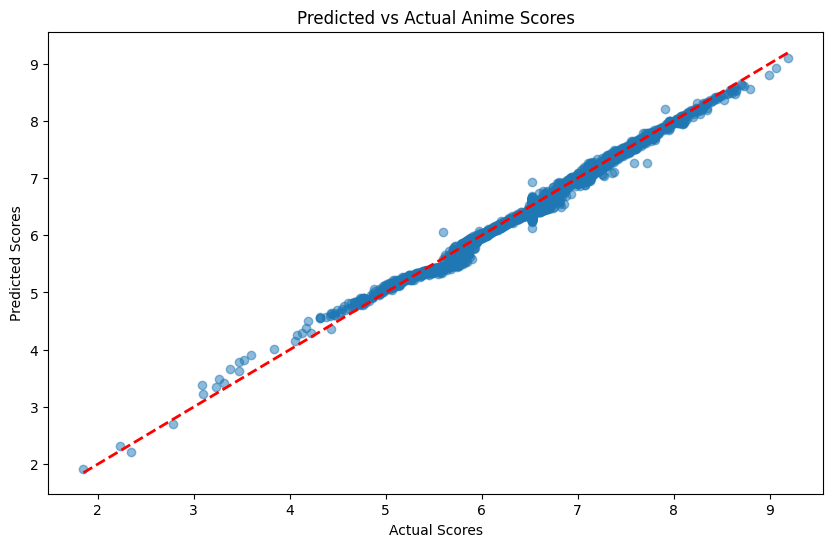

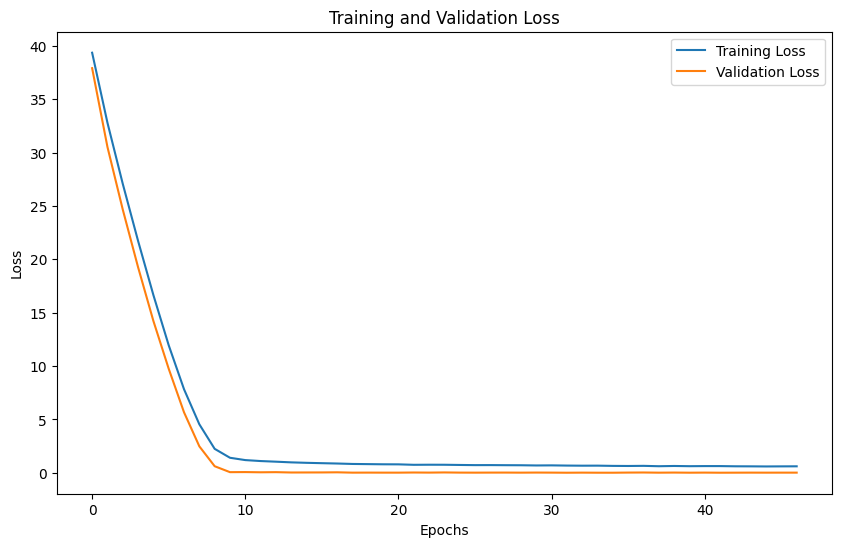

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(val_true_scores, val_predictions, alpha=0.5)
plt.plot([val_true_scores.min(), val_true_scores.max()], [val_true_scores.min(), val_true_scores.max()], 'r--', lw=2)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Anime Scores")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

get result

In [24]:
def get_recommendations(input_anime, anime_df, anime_features, top_n=10):
    model.eval()
    with torch.no_grad():
        input_with_id = pd.merge(input_anime, anime_df[['MAL_ID', 'Name']], left_on='Title', right_on='Name', how='left')
        rated_anime_ids = input_with_id['MAL_ID'].tolist()
        unseen_anime = anime_features[~anime_features['MAL_ID'].isin(rated_anime_ids)].copy()
        feature_columns = ['Score', 'Episodes', 'Members', 'Popularity', 'Ranked', 'genre_count', 'synopsis_length']
        unseen_features = unseen_anime[feature_columns]

        unseen_scaled = scaler.transform(unseen_features)
        unseen_tensor = torch.FloatTensor(unseen_scaled).to(device)
        predicted_ratings = model(unseen_tensor).cpu().numpy().flatten()

    unseen_anime.loc[:, 'Predicted_Rating'] = predicted_ratings
    recommendations = unseen_anime.sort_values('Predicted_Rating', ascending=False).head(top_n)
    
    recommendations = pd.merge(recommendations, anime_df[['MAL_ID', 'Name']], on='MAL_ID', how='left')
    
    return recommendations[['Name', 'Predicted_Rating']]

User input

In [25]:
userInput = [
    {'Title': 'Boku dake ga Inai Machi', 'Rating': 10.0},
    {'Title': 'Violet Evergarden', 'Rating': 9.5},
    {'Title': 'Goblin Slayer', 'Rating': 6.0},
    {'Title': 'Berserk', 'Rating': 8.0},
    {'Title': 'Shingeki no Kyojin', 'Rating': 7.0},
    {'Title': 'Tokyo Ghoul', 'Rating': 6.5},
    {'Title': 'Orange', 'Rating': 6.0},
    {'Title': 'Death Parade', 'Rating': 8.0},
    {'Title': 'Death Note', 'Rating': 7.5},
    {'Title': 'Bungou Stray Dogs', 'Rating': 7.5},
    {'Title': 'Tenki no Ko', 'Rating': 8.0},
    {'Title': 'Kimi no Na wa.', 'Rating': 8.0},
    {'Title': 'Kimi no Suizou wo Tabetai', 'Rating': 8.5},
    {'Title': 'Mononoke Hime', 'Rating': 7.5},
    {'Title': 'Sen to Chihiro no Kamikakushi', 'Rating': 7.5},
    {'Title': 'Koe no Katachi', 'Rating': 8.5},
    {'Title': 'Ao Haru Ride', 'Rating': 5.5},
    {'Title': 'Toki wo Kakeru Shoujo', 'Rating': 7.0},
    {'Title': 'Another', 'Rating': 7.5},
    {'Title': 'Kimetsu no Yaiba', 'Rating': 7.0},
    {'Title': 'Shigatsu wa Kimi no Uso', 'Rating': 8.0},
    {'Title': 'Byousoku 5 Centimeter', 'Rating': 6.0},
    {'Title': 'Kokoro ga Sakebitagatterunda.', 'Rating': 7.5},
    {'Title': 'Schick x Evangelion', 'Rating': 5.0}
]

inputAnime = pd.DataFrame(userInput)
print(inputAnime)

                            Title  Rating
0         Boku dake ga Inai Machi    10.0
1               Violet Evergarden     9.5
2                   Goblin Slayer     6.0
3                         Berserk     8.0
4              Shingeki no Kyojin     7.0
5                     Tokyo Ghoul     6.5
6                          Orange     6.0
7                    Death Parade     8.0
8                      Death Note     7.5
9               Bungou Stray Dogs     7.5
10                    Tenki no Ko     8.0
11                 Kimi no Na wa.     8.0
12      Kimi no Suizou wo Tabetai     8.5
13                  Mononoke Hime     7.5
14  Sen to Chihiro no Kamikakushi     7.5
15                 Koe no Katachi     8.5
16                   Ao Haru Ride     5.5
17          Toki wo Kakeru Shoujo     7.0
18                        Another     7.5
19               Kimetsu no Yaiba     7.0
20        Shigatsu wa Kimi no Uso     8.0
21          Byousoku 5 Centimeter     6.0
22  Kokoro ga Sakebitagatterunda. 

In [26]:
recommendations = get_recommendations(inputAnime, anime_df, anime_features)
print("\nTop 10 Recommended Anime:")
print(recommendations)


Top 10 Recommended Anime:
                                   Name  Predicted_Rating
0      Fullmetal Alchemist: Brotherhood          9.102803
1                           Steins;Gate          9.024854
2  Shingeki no Kyojin: The Final Season          8.962355
3                Hunter x Hunter (2011)          8.961122
4                              Gintama°          8.956195
5                              Gintama'          8.932238
6                  Ginga Eiyuu Densetsu          8.916230
7    Shingeki no Kyojin Season 3 Part 2          8.887760
8                   Gintama': Enchousen          8.849948
9            3-gatsu no Lion 2nd Season          8.849866
